In [1]:
import itertools
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, \
    DetCurveDisplay, RocCurveDisplay

In [2]:
data = pd.read_csv('maladie_cardiaque.csv', usecols=lambda column: column != 'Unnamed: 0', index_col='id')

In [3]:
def transform_dataframe(data):
    # Ajouter une colonne 'age_annee'
    data["age_annee"] = round(data["age"] / 365.25, 2)

    # Créer les intervalles pour les classes d'âge
    bins = [0, 18, 30, 45, 60, 100]

    # Créer les étiquettes pour les classes d'âge
    labels = ['moins de 18 ans', '18-30 ans', '30-45 ans', '45-60 ans', 'plus de 60 ans']

    # Créer une nouvelle colonne 'classe_age' en utilisant la méthode cut()
    data['classe_age'] = pd.cut(data['age_annee'], bins=bins, labels=labels)

    # Convertir les colonnes 'malade', 'fumeur' et 'conso_alco' en 0/1
    data['malade'] = data["malade"].map({'oui': 1, 'non': 0})
    data['fumeur'] = data["fumeur"].map({'fumeur': 1, 'non fumeur': 0})
    data['conso_alco'] = data["conso_alco"].map({'oui': 1, 'non': 0})

    # Ajouter une colonne 'IMC_Category'
    def imc_category(row):
        taille_m = row['taille'] / 100  # Convertir la taille en mètres
        imc = row['Poids'] / (taille_m ** 2)  # Calculer l'IMC
        if imc < 18.5:
            return 'Maigre'
        elif imc < 25:
            return 'Normal'
        elif imc < 30:
            return 'Surpoids'
        else:
            return 'Obèse'

    data['IMC'] = data.apply(lambda row: row['Poids'] / ((row['taille'] / 100) ** 2), axis=1)
    data['IMC_Category'] = data.apply(imc_category, axis=1)

    # Appliquer get_dummies sur les colonnes catégorielles
    cat_cols = data.select_dtypes(exclude=['int64', 'float64']).columns
    cat_cols = list(cat_cols)
    cat_cols.append("glycemie")
    df_onehot = pd.get_dummies(data, columns=cat_cols)

    # Supprimer les colonnes non nécessaires
    df_onehot = df_onehot.drop(
        ['classe_age_moins de 18 ans', 'genre_homme', 'age_annee', 'age', 'Poids', 'taille', 'IMC'], axis=1)

    return df_onehot


def imc_category(row):
    """
    Calcule la catégorie de l'IMC (Indice de Masse Corporelle) en fonction de la taille et du poids d'une personne.

    Args:
        row (pandas Series): une ligne d'un DataFrame contenant les informations sur le poids et la taille d'une personne.

    Returns:
        str: la catégorie de l'IMC calculée, qui peut être l'une des suivantes:
            - Maigre: si l'IMC est inférieur à 18.5
            - Normal: si l'IMC est compris entre 18.5 et 25
            - Surpoids: si l'IMC est compris entre 25 et 30
            - Obèse: si l'IMC est supérieur à 30
    """

    taille_m = row['taille'] / 100  # Convertir la taille en mètres
    imc = row['Poids'] / (taille_m ** 2)  # Calculer l'IMC
    if imc < 18.5:
        return 'Maigre'
    elif imc < 25:
        return 'Normal'
    elif imc < 30:
        return 'Surpoids'
    else:
        return 'Obèse'


def print_nice_conf_matrix(y, cnf_matrix):
    """
    Rend une matrice de confusion agréable à lire à partir d'une matrice de confusion et des classes pour la classification.

    Args:
        y (numpy array): un array contenant les classes pour la classification.
                         Sert uniquement à compter le nombre de classes.
        cnf_matrix (numpy array): la matrice de confusion à rendre agréable à lire.

    Returns:
        None: la fonction affiche la matrice de confusion avec une coloration de fond et un texte facilement lisible pour
        chaque cellule.
    """
    classes = range(0, (len(np.unique(y))))

    plt.figure()

    plt.imshow(cnf_matrix, interpolation='nearest', cmap='Blues')
    plt.title("Matrice de confusion")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > (cnf_matrix.max() / 2) else "black")

    plt.ylabel('Vrais labels')
    plt.xlabel('Labels prédits')
    plt.show()

In [4]:
df = transform_dataframe(data)

In [5]:
with open('rfecv.pkl', 'rb') as file:
    # Call load method to deserialze
    rfe = pkl.load(file)

In [6]:
X = df.drop('malade', axis=1)
y = df['malade']

In [7]:
X = rfe.transform(X)
# Diviser les données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


D:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


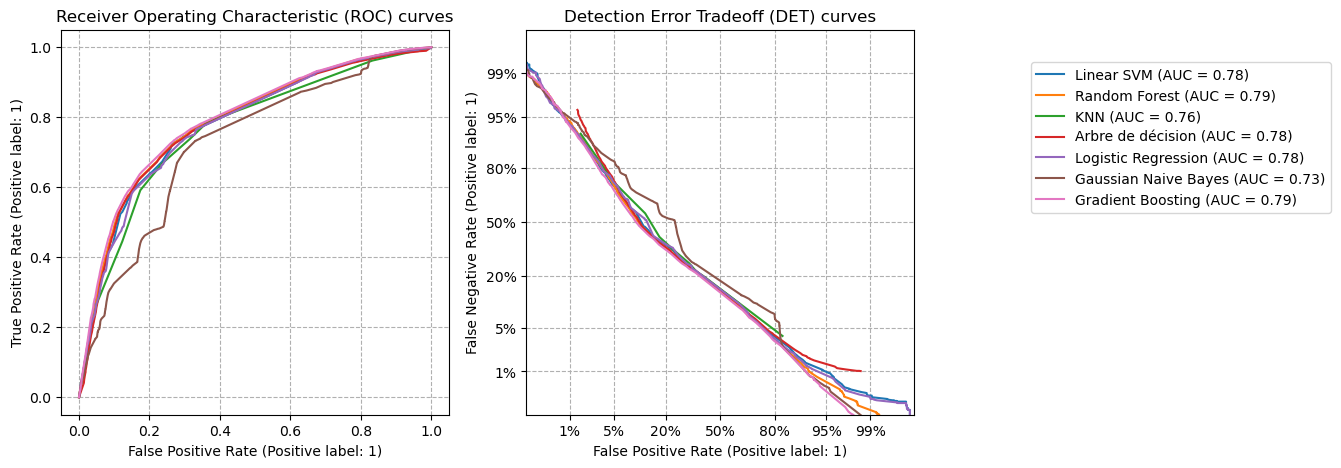

In [8]:
classifiers = {
    "Linear SVM": make_pipeline(LinearSVC(C=0.025)),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(n_neighbors=9),
    "Arbre de décision": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier()
}

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)

    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc, name=name)
    DetCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_det, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

# Supprimer les légendes ajoutées par RocCurveDisplay et DetCurveDisplay
for ax in [ax_roc, ax_det]:
    ax.legend_.remove()

# Créer une seule légende pour les deux graphiques à droite de la figure
lines, labels = ax_roc.get_legend_handles_labels()
fig.legend(lines, labels, loc='lower left', bbox_to_anchor=(1.0, 0.5))

plt.show()


D:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\svm\_bas

D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avo

D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avo

D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avo

D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avo

D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avo

D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avo

D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avo

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

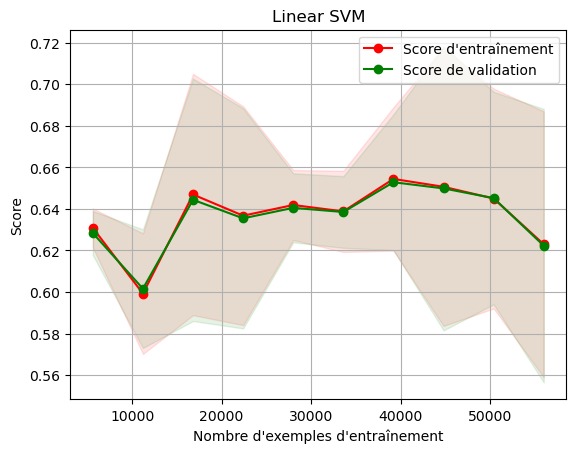

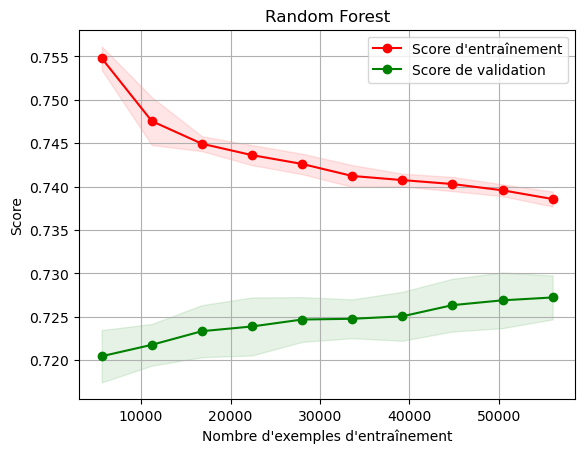

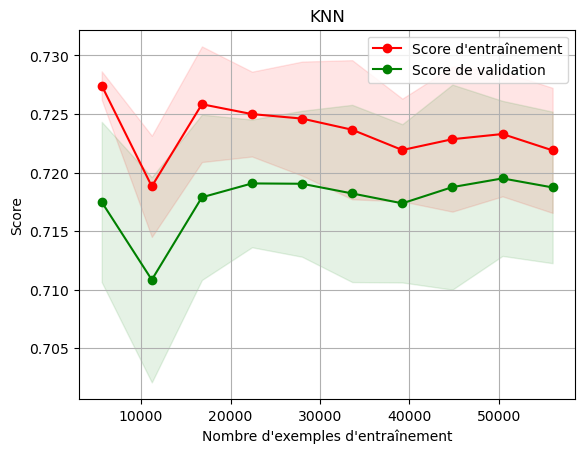

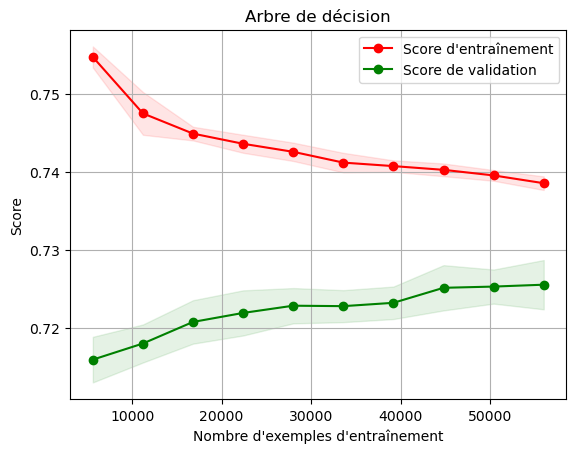

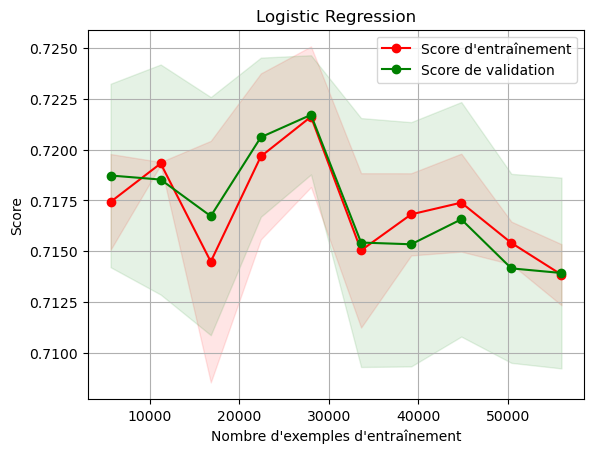

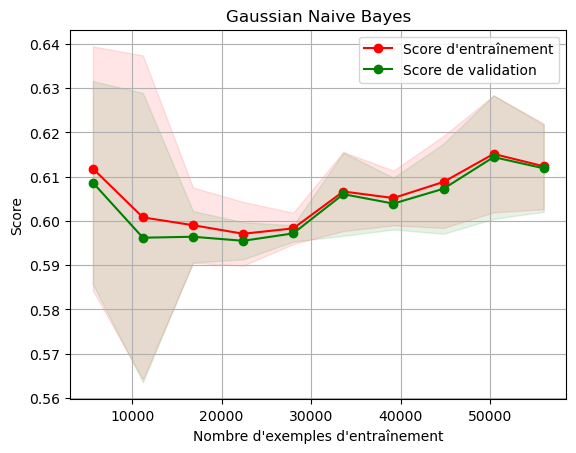

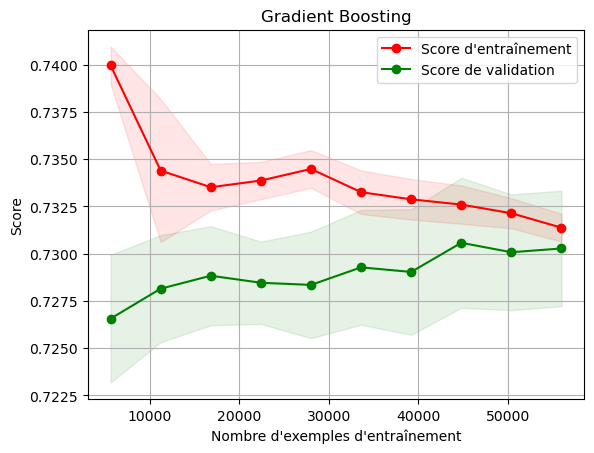

In [9]:
# Définir les classifieurs
classifiers = {
    "Linear SVM": make_pipeline(LinearSVC(C=0.025)),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(n_neighbors=9),
    "Arbre de décision": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# Définir les paramètres de la fonction learning_curve
cv = 5  # nombre de folds pour la validation croisée
train_sizes = np.linspace(0.1, 1.0, 10)  # nombre d'exemples d'entraînement à utiliser (en pourcentage du nombre total)

# Boucle sur les classifieurs
for name, clf in classifiers.items():
    # Calculer les courbes d'apprentissage pour le classifieur
    train_sizes, train_scores, test_scores = learning_curve(clf, X, y, cv=cv, train_sizes=train_sizes)

    # Calculer les scores moyens et les écarts-types pour chaque nombre d'exemples d'entraînement
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Afficher la courbe d'apprentissage pour le classifieur
    plt.figure()
    plt.title(name)
    plt.xlabel("Nombre d'exemples d'entraînement")
    plt.ylabel("Score")
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Score d'entraînement")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Score de validation")
    plt.legend(loc="best")

plt.show()


In [29]:
X = df.drop('malade', axis=1)
X = rfe.transform(X)
y = df['malade']

# Définir les classifieurs
classifiers = {
    "Linear SVM": LinearSVC(C=0.025, max_iter=200),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(n_neighbors=9),
    "Arbre de décision": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Gaussian Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier()
}

resultats = {}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

for index, (name, classifier) in enumerate(classifiers.items()):
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    resultats[name] = accuracy * 100
    #print("Accuracy (test) for %s: %0.1f%% " % (name, accuracy * 100))


D:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [30]:
resultats

{'Linear SVM': 49.865800865800864,
 'Random Forest': 72.8051948051948,
 'KNN': 71.58008658008657,
 'Arbre de décision': 72.65800865800865,
 'Logistic Regression': 71.3939393939394,
 'Gaussian Naive Bayes': 62.316017316017316,
 'Gradient Boosting': 73.27705627705627}

In [34]:
# Définir les hyperparamètres pour chaque algorithme
param_grid = {
    'Random Forest': {'n_estimators': [100, 200, 500],
                      'max_depth': [3, 5, 7, 10],
                      'min_samples_split': [2, 5, 10]},
    'KNN': {'n_neighbors': [7, 9, 12],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]},
    'Arbre de décision': {'max_depth': [7, 10, 12],
                          'min_samples_split': [2, 5, 10]},
    'Logistic Regression': {'C': [0.1, 1, 10],
                            'penalty': ['l1', 'l2']},
    'Gradient Boosting': {'n_estimators': [100, 200, 500],
                          'learning_rate': [0.01, 0.1, 1],
                          'max_depth': [3, 5, 7]}
}

# Créer les classifieurs à tester
classifiers = {
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Arbre de décision': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier()
}

# Sélectionner les classifieurs avec une précision supérieure à 70%
selected_classifiers = {k: v for k, v in classifiers.items() if
                        k in ['Random Forest', 'KNN', 'Arbre de décision', 'Logistic Regression', 'Gradient Boosting']}
resultats2 = {}
best_params = {}
# Effectuer la recherche sur grille avec la validation croisée
for clf_name, clf in selected_classifiers.items():
    print(f"Training {clf_name}")
    grid = GridSearchCV(clf, param_grid[clf_name], cv=3)
    grid.fit(X_train, y_train)
    resultats2[clf_name] = grid.score(X_test, y_test) * 100
    print(f"Best parameters for {clf_name}: {grid.best_params_}")
    print(f"Accuracy on test set for {clf_name}: {grid.score(X_test, y_test)}")
    best_params[clf_name] = grid.best_params_


Training Random Forest
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy on test set for Random Forest: 0.7304329004329004
Training KNN


D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avo

D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avo

Best parameters for KNN: {'n_neighbors': 12, 'p': 1, 'weights': 'uniform'}


D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Accuracy on test set for KNN: 0.7156277056277056
Training Arbre de décision
Best parameters for Arbre de décision: {'max_depth': 7, 'min_samples_split': 2}
Accuracy on test set for Arbre de décision: 0.7297402597402597
Training Logistic Regression


D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

Best parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l2'}
Accuracy on test set for Logistic Regression: 0.7139826839826839
Training Gradient Boosting
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Accuracy on test set for Gradient Boosting: 0.7317316017316017


In [36]:
resultats2

{'Random Forest': 73.04329004329004,
 'KNN': 71.56277056277057,
 'Arbre de décision': 72.97402597402596,
 'Logistic Regression': 71.3982683982684,
 'Gradient Boosting': 73.17316017316017}

In [35]:
best_params

{'Random Forest': {'max_depth': 10,
  'min_samples_split': 10,
  'n_estimators': 100},
 'KNN': {'n_neighbors': 12, 'p': 1, 'weights': 'uniform'},
 'Arbre de décision': {'max_depth': 7, 'min_samples_split': 2},
 'Logistic Regression': {'C': 0.1, 'penalty': 'l2'},
 'Gradient Boosting': {'learning_rate': 0.1,
  'max_depth': 5,
  'n_estimators': 100}}

In [37]:
# Créer les classifieurs avec les meilleurs hyperparamètres trouvés précédemment
rf = RandomForestClassifier(**best_params['Random Forest'])
knn = KNeighborsClassifier(**best_params['KNN'])
dt = DecisionTreeClassifier(**best_params['Arbre de décision'])
lr = LogisticRegression(**best_params['Logistic Regression'])
gb = GradientBoostingClassifier(**best_params['Gradient Boosting'])
# Créer le classificateur de stacking avec un arbre de décision comme voteur final
estimators = [('Random Forest', rf), ('KNN', knn), ('Decision Tree', dt), ('Logistic Regression', lr),
              ('Gradient Boosting', gb)]
stacking_classifier = StackingClassifier(estimators=estimators, final_estimator=DecisionTreeClassifier())

# Entraîner le classificateur de stacking sur l'ensemble d'entraînement
stacking_classifier.fit(X_train, y_train)

# Évaluer les performances du classificateur de stacking sur l'ensemble de test
print("Accuracy on test set with stacking classifier:", stacking_classifier.score(X_test, y_test))


D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

Accuracy on test set with stacking classifier: 0.7017748917748918


In [42]:
# Créer les classifieurs avec les meilleurs hyperparamètres trouvés précédemment
rf = RandomForestClassifier(**best_params['Random Forest'])
knn = KNeighborsClassifier(**best_params['KNN'])
dt = DecisionTreeClassifier(**best_params['Arbre de décision'])
lr = LogisticRegression(**best_params['Logistic Regression'])
gb = GradientBoostingClassifier(**best_params['Gradient Boosting'])

# Créer le modèle de vote majoritaire
voting_classifier = VotingClassifier(
    estimators=[('Random Forest', rf), ('KNN', knn), ('Decision Tree', dt), ('Logistic Regression', lr)
        , ('Gradient Boosting', gb)], voting='hard')

# Entraîner le modèle de vote majoritaire sur l'ensemble d'entraînement
voting_classifier.fit(X_train, y_train)

# Évaluer les performances du modèle de vote majoritaire sur l'ensemble de test
print("Accuracy on test set with voting classifier:", voting_classifier.score(X_test, y_test))


D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = sta

Accuracy on test set with voting classifier: 0.7314285714285714


Comparaison Métrics voting classifier / gradient Boosting pour choisir le modèle final

In [44]:
gb.fit(X_train, y_train)
voting_classifier.fit(X_train, y_train)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('Random Forest',
                              RandomForestClassifier(max_depth=10,
                                                     min_samples_split=10)),
                             ('KNN', KNeighborsClassifier(n_neighbors=12, p=1)),
                             ('Decision Tree',
                              DecisionTreeClassifier(max_depth=7)),
                             ('Logistic Regression', LogisticRegression(C=0.1)),
                             ('Gradient Boosting',
                              GradientBoostingClassifier(max_depth=5))])

D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Classification Report for Gradient Boosting:
               precision    recall  f1-score   support

           0       0.71      0.77      0.74     11506
           1       0.76      0.69      0.72     11594

    accuracy                           0.73     23100
   macro avg       0.73      0.73      0.73     23100
weighted avg       0.73      0.73      0.73     23100

Classification Report for Voting Classifier:
               precision    recall  f1-score   support

           0       0.71      0.77      0.74     11506
           1       0.75      0.69      0.72     11594

    accuracy                           0.73     23100
   macro avg       0.73      0.73      0.73     23100
weighted avg       0.73      0.73      0.73     23100



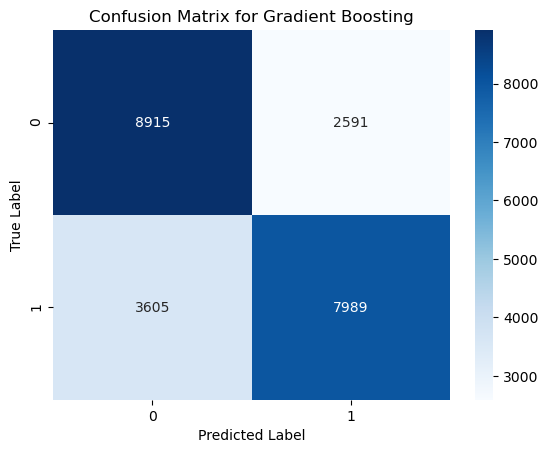

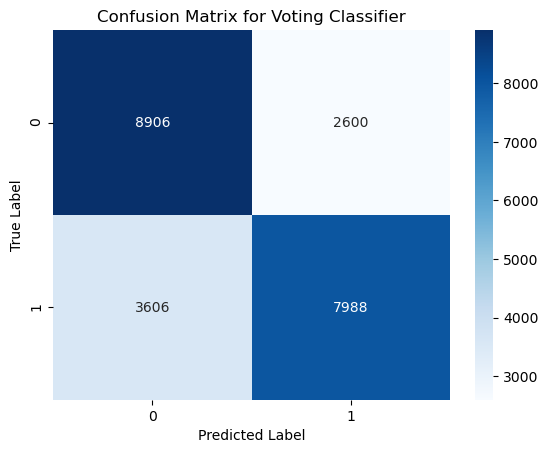

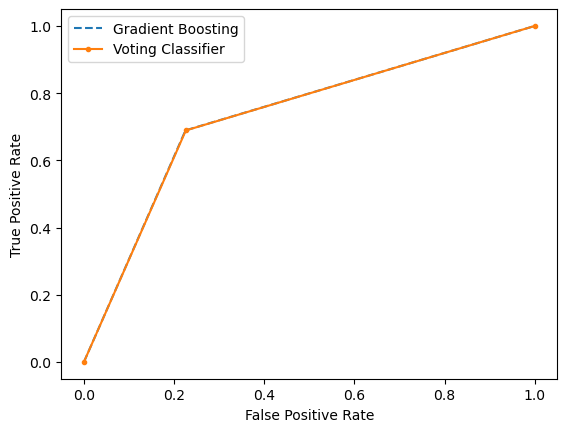

ROC AUC Score for Gradient Boosting: 0.7319382247889146
ROC AUC Score for Voting Classifier: 0.731503998738716


In [46]:
# Faire des prédictions avec le modèle de Gradient Boosting
gb_preds = gb.predict(X_test)

# Calculer les métriques de performance pour le modèle de Gradient Boosting
gb_report = classification_report(y_test, gb_preds)
gb_matrix = confusion_matrix(y_test, gb_preds)
gb_roc_auc = roc_auc_score(y_test, gb_preds)

# Faire des prédictions avec le modèle de vote majoritaire
vc_preds = voting_classifier.predict(X_test)

# Calculer les métriques de performance pour le modèle de vote majoritaire
vc_report = classification_report(y_test, vc_preds)
vc_matrix = confusion_matrix(y_test, vc_preds)
vc_roc_auc = roc_auc_score(y_test, vc_preds)

# Afficher les rapports de classification pour les deux modèles
print("Classification Report for Gradient Boosting:\n", gb_report)
print("Classification Report for Voting Classifier:\n", vc_report)

sns.heatmap(gb_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Gradient Boosting")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Afficher la matrice de confusion pour le modèle de vote majoritaire
sns.heatmap(vc_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Voting Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Afficher les courbes ROC pour les deux modèles
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_preds)
fpr_vc, tpr_vc, _ = roc_curve(y_test, vc_preds)

plt.plot(fpr_gb, tpr_gb, linestyle='--', label='Gradient Boosting')
plt.plot(fpr_vc, tpr_vc, marker='.', label='Voting Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.show()

# Afficher les scores AUC pour les deux modèles
print("ROC AUC Score for Gradient Boosting:", gb_roc_auc)
print("ROC AUC Score for Voting Classifier:", vc_roc_auc)


In [49]:
from sklearn.model_selection import cross_val_score

# Effectuer une validation croisée pour le modèle de Gradient Boosting
gb_scores = cross_val_score(classifier_gb, X, y, cv=6, scoring='accuracy')
print(f"Gradient Boosting Cross Validation Accuracy: {np.mean(gb_scores):.2f} +/- {np.std(gb_scores):.2f}")

# Effectuer une validation croisée pour le modèle de vote majoritaire
vc_scores = cross_val_score(classifier_vc, X, y, cv=6, scoring='accuracy')
print(f"Voting Classifier Cross Validation Accuracy: {np.mean(vc_scores):.2f} +/- {np.std(vc_scores):.2f}")


Gradient Boosting Cross Validation Accuracy: 0.73 +/- 0.00


D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = sta

Voting Classifier Cross Validation Accuracy: 0.73 +/- 0.00


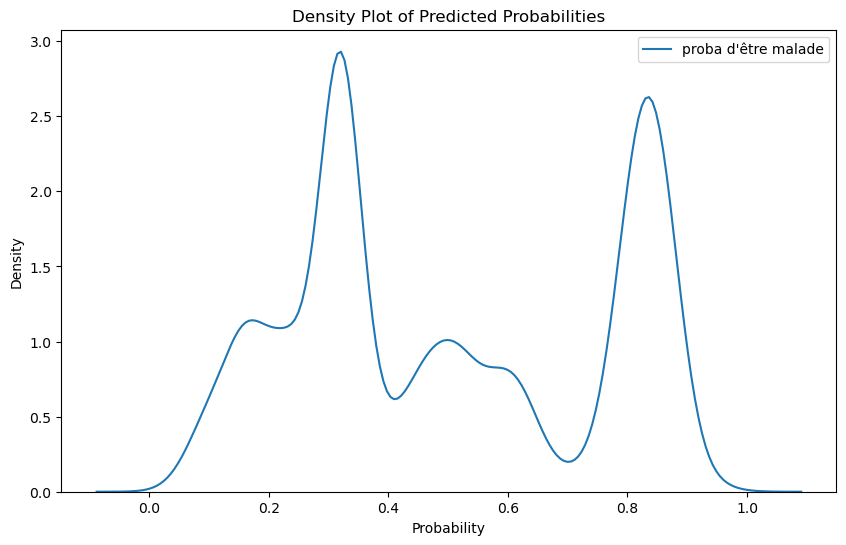

In [50]:
proba_pred = gb.predict_proba(X_test)

# créer un graphique de densité pour chaque classe prédite
plt.figure(figsize=(10, 6))
sns.kdeplot(proba_pred[:, 1], label="proba d'être malade")
plt.xlabel('Probability')
plt.ylabel('Density')
plt.title('Density Plot of Predicted Probabilities')
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.74      0.68      0.71     11506
           1       0.71      0.77      0.74     11594

    accuracy                           0.72     23100
   macro avg       0.72      0.72      0.72     23100
weighted avg       0.72      0.72      0.72     23100



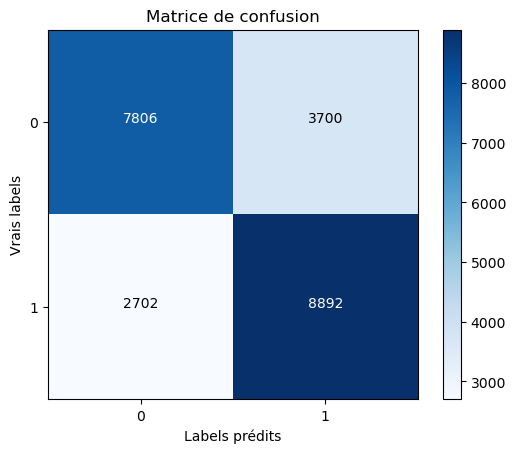

In [57]:
test = []
for prob in proba_pred:
    if prob[1] < 0.38:
        test.append(0)
    else:
        test.append(1)

print(classification_report(y_test, test))
cm = confusion_matrix(y_test, test)
print_nice_conf_matrix(y_test, cm)

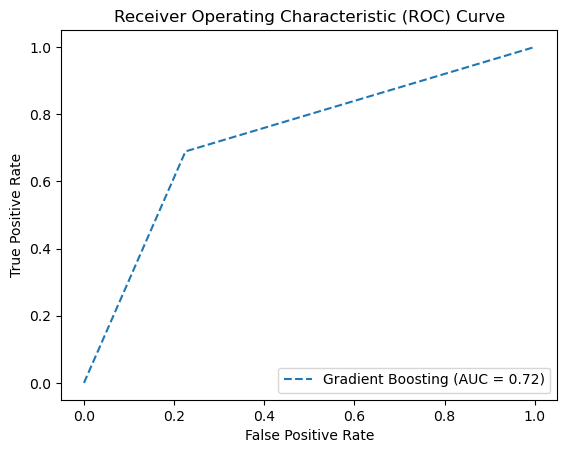

In [61]:
fpr_vc, tpr_vc, _ = roc_curve(y_test, test)
auc_gb = roc_auc_score(y_test, test)

plt.plot(fpr_gb, tpr_gb, linestyle='--', label=f'Gradient Boosting (AUC = {auc_gb:.2f})')
# Ajouter des titres et des légendes pour les graphiques
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [51]:
proba_pred = voting_classifier.predict_proba(X_test)

# créer un graphique de densité pour chaque classe prédite
plt.figure(figsize=(10, 6))
sns.kdeplot(proba_pred[:, 1], label="proba d'être malade")
plt.xlabel('Probability')
plt.ylabel('Density')
plt.title('Density Plot of Predicted Probabilities')
plt.legend()
plt.show()

AttributeError: predict_proba is not available when voting='hard'